Chambolle-Pock Primal-Dual Splitting Algorithm
==============================
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$


We have seen in the lab 3 that total variation denoising can be performed using the dual forward-backward algorithm. But the setting is restrictive: this algorithm cannot be applied to general inverse problems. 

This tour explores the primal-dual proximal splitting algorithm proposed in 

A. Chambolle and T. Pock, "A First-order primal-dual algorithm for convex problems with application to imaging,"
_Journal of Mathematical Imaging and Vision_,
vol. 40, no. 1, 2011

and further analyzed and extended in 

L. Condat, "A primal-dual splitting method for convex optimization involving Lipschitzian, proximable and linear composite terms," _J. Optimization Theory and Applications_, vol. 158, no. 2, 2013.

In [3]:
from __future__ import division
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Convex Optimization with a Primal-Dual Scheme
---------------------------------------------

We consider a (primal) optimization problem of the form
$$ \umin{x} f(x) + g(Lx) $$
where $f$ and $g$ are convex functions, whose proximity operators can be computed, and $L$
is a linear operator.

The dual problem is 

$$ \umin{u} f^*(-L^*u) + g^*(u) $$

The (relaxed) Chambolle-Pock algorithm takes initial estimates $x^{(0)}$ and $u^{(0)}$ of the primal and dual solutions, a parameter $\tau>0$, a second parameter $0<\sigma\leq 1/(\tau\|L\|^2)$, a relaxation parameter $0<\rho<2$, and iterates, for $k=1,2,\ldots$
$$ \left|\begin{array}{l}
\tilde{x}^{(k)} = \mathrm{prox}_{\tau f}(  x^{(k-1)}-\tau L^*(u^{(k-1)}) ) \\
 \tilde{u}^{(k)} = \mathrm{prox}_{\sigma g^*}( u^{(k-1)}+ \sigma L(2\tilde{x}^{(k)}-x^{(k-1)}) \\
 x^{(k)}= x^{(k-1)} + \rho (\tilde{x}^{(k)}-x^{(k-1)})\\
 u^{(k)}= u^{(k-1)} + \rho (\tilde{u}^{(k)}-u^{(k-1)})
 \end{array}\right.$$
 
 Then, $x^{(k)}$ converges to a primal solution $x^\star$ and $u^{(k)}$ converges to a dual solution $u^\star$.
 
 In practice, like for the Douglas-Rachford algorithm, it is always interesting to take $\rho$ close to $2$, e.g. $\rho=1.9$, instead of $\rho=1$ like in the paper of Chambolle & Pock. Also, for fixed $\tau$, the higher $\sigma$, the better; so, one can set $\sigma=1/(\tau\|L\|^2)$, which leaves only the parameter $\tau$ to tune.

With this choice of $\sigma$, the algorithm exactly reverts to the Douglas-Rachford algorithm when $L=\mathrm{Id}$ (replacing $\sigma$ by $1/\tau$ in the algorithm). So, it is a natural extension of the latter.


We recall that being able to compute the proximity operator of $f^*$ is
equivalent to being able to compute the proximity operator of $f$, thanks to the Moreau identity
$$ x = \mathrm{prox}_{\gamma f^*}(x) + \gamma \mathrm{prox}_{f/\gamma}(x/\gamma) $$

Image Inpainting
---------------------------------------------

Like in the lab 1, we want to reconstruct an estimate of the Lena image from a random subset of its pixels. So, we want to solve 
$$\umin{x} \mathrm{TV}(x)\quad\mbox{s.t.}\quad Ax=b,$$
where we keep the notations of the labs 1 and 3: $A$ is the degradation operator which multiplies the image by a binary mask and $\mathrm{TV}$ is the total variation.

<h3><font color='magenta'>
__Exercise: write the code of the Chambolle-Pock algorithm to solve this inpainting problem and apply it to the Lena image.__

Try different values of $\tau$ and $\rho$ and observe the convergence speed by monitoring the decay of $\mathrm{TV}(x^{(k)})$.

Compare the inpainted image with the one obtained in the lab 1, with Tikhonov instead of total variation regularization.
</font></h3>

In [4]:
from scipy import misc
xsharp = misc.ascent()
print(xsharp.shape) # like Matlab's size(xsharp). Given as a tuple.
print("The size of the image is %s x %s." % (xsharp.shape[0],xsharp.shape[1]))
print("The range of the pixel values is [%s,%s]." % (xsharp.min(),xsharp.max()))
xsharp = xsharp.astype(float32) 

(512, 512)
The size of the image is 512 x 512.
The range of the pixel values is [0,255].


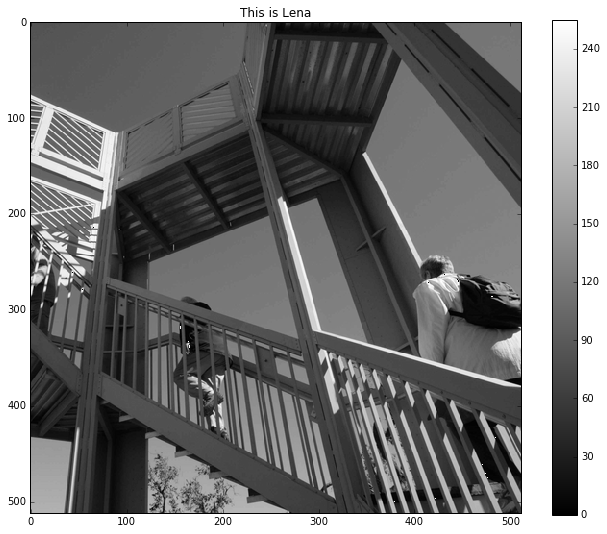

In [5]:
figsize(11,11)
imshow(xsharp, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
# Without specifying vmin and vmax, imshow auto-adjusts its range so that black and white are
# the min and max of the data, respectively, like Matlab's imagesc.
colorbar()       # displays the color bar close to the image
#axis('off')     # uncomment to remove the axes
subplots_adjust(top=0.75)
title('This is Ascent')

In [6]:
mask = rand(xsharp.shape[0],xsharp.shape[1])>0.80

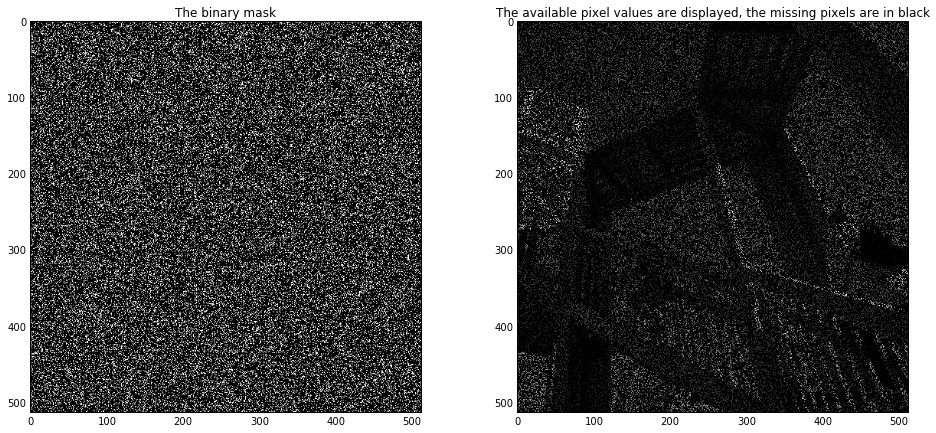

In [7]:
fig, (subfig1,subfig2) = subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.imshow(mask, cmap=cm.gray)
subfig2.imshow(mask*xsharp, cmap=cm.gray)
subfig1.set_title('The binary mask')
subfig2.set_title('The available pixel values are displayed, the missing pixels are in black')

In [8]:
y = mask*xsharp

In [9]:
D = lambda x : c_['2,3',r_[diff(x,1,0), zeros([1,x.shape[1]])],c_[diff(x,1,1), zeros([x.shape[0],1])]]

In [10]:
Dadj = lambda v : r_['0,2',-v[0,:,0],-diff(v[:-1,:,0],1,0),v[-2,:,0]] + c_['1,2',-v[:,0,1],-diff(v[:,:-1,1],1,1),v[:,-2,1]]

In [11]:
def prox_g_conj (u, Lambda) :
    return u/tile(maximum(sqrt(sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

In [12]:
A = mask

In [13]:
def prox_f (x, y) :
    x[mask]=y[mask]
    return x

In [14]:
tau = 1
rho = 1
sigma = 1/tau
nbiter = 1500

(N1,N2) = shape(xsharp)
x = zeros([N1,N2])
u = zeros([N1,N2, 2])
En_array = zeros(nbiter)
for iter in range(nbiter):  # iter goes from 0 to nbiter-1
    xtilde = prox_f(x - tau*Dadj(u),y)
    utilde = prox_g_conj(u + sigma*D(2*xtilde-x), sigma)
    x = x + rho*(xtilde - x)
    u = u + rho*(utilde - u)
    En_array[iter] = sum(sqrt(sum(D(x)**2,2)))
    
x_restored = x

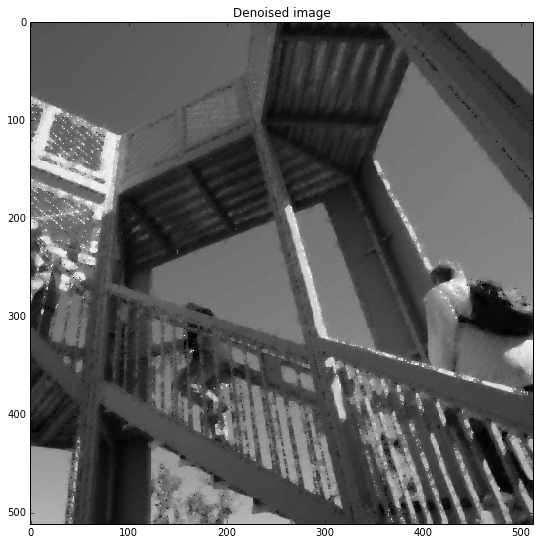

In [15]:
figsize(9,9)
imshow(x_restored, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
title('Denoised image')

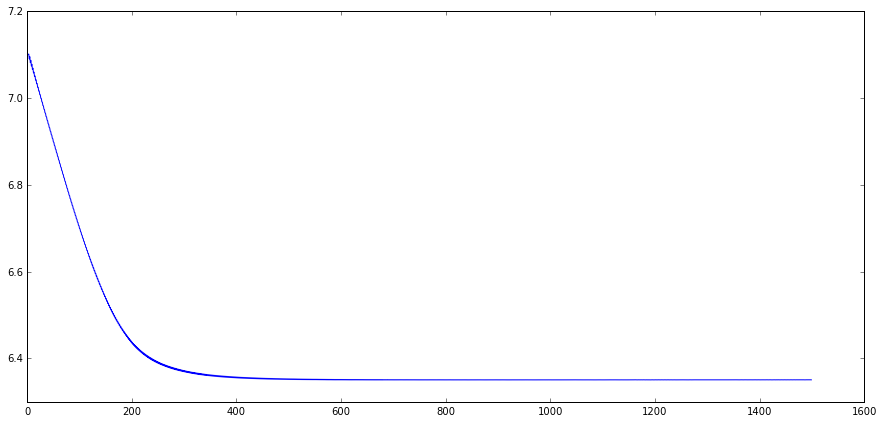

In [16]:
figsize(15,7)
plot(log10(En_array))

Image Denoising
---------------------------------------------
Like in the lab 3, we want to denoise the noisy Lena image by solving 
$$\umin{x} \frac{1}{2}\|x-y\|^2+\lambda\mathrm{TV}(x).$$

<h3><font color='magenta'>
__Exercise: write the code of the Chambolle-Pock algorithm to solve this denoising problem and apply it to the Lena image.__

Try different values of $\tau$ and $\rho$ and observe the convergence speed by monitoring the sum of the primal and dual energies, like in the lab 3. Compare with the accelerated forward-backward algorithm on the dual problem developed in the lab 3.
</font></h3>

In [17]:
(N1,N2) = shape(xsharp)
noiselevel = 20
y = xsharp + noiselevel * randn(N1,N2)

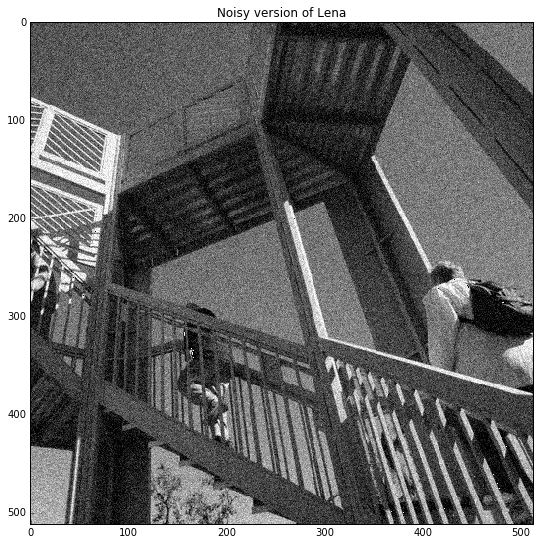

In [18]:
figsize(9,9)
imshow(y, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
title('Noisy version of Lena')

In [19]:
def prox_g (x) :
    #Now A is identity
    return x
def prox_f_conj_1 (p, y, sigma) :
    return (1/(1+sigma))*(p-sigma*y)
def prox_f_conj_2 (u, Lambda) :
    return Lambda * u/tile(maximum(sqrt(sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

In [20]:
tau = 1/10
sigma = 1/10
rho = 1
nbiter = 1500
lambdaTV = 5

(N1,N2) = shape(xsharp)
utilde = zeros([N1,N2])
u1 = zeros([N1,N2])
p = zeros([N1,N2])
q = zeros([N1,N2, 2])
En_array = zeros(nbiter)
for iter in range(nbiter):
    p = prox_f_conj_1( p + sigma * utilde, y, sigma ) 
    q = prox_f_conj_2(q + sigma*D(utilde),lambdaTV )
    u = prox_g( u1 - tau * p - tau * Dadj( q ) )
    utilde = u + rho*( u - u1 )
    En_array[iter] = lambdaTV * sum(sqrt(sum(D(u)**2,2))) + sum(sum((u-y)**2))
    
x_restored = u

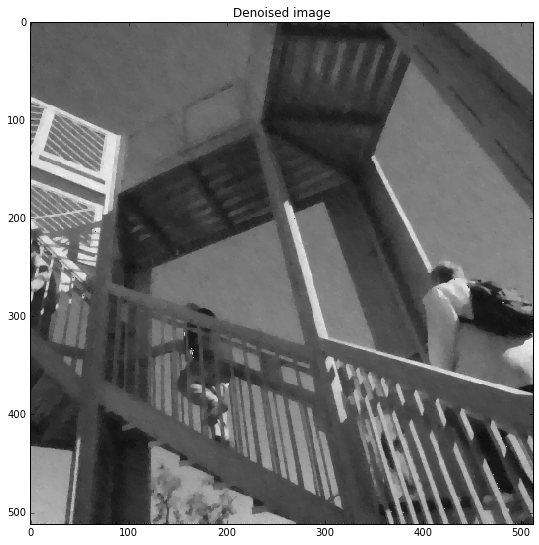

In [21]:
figsize(9,9)
imshow(x_restored, interpolation='nearest', cmap=cm.gray )
title('Denoised image')

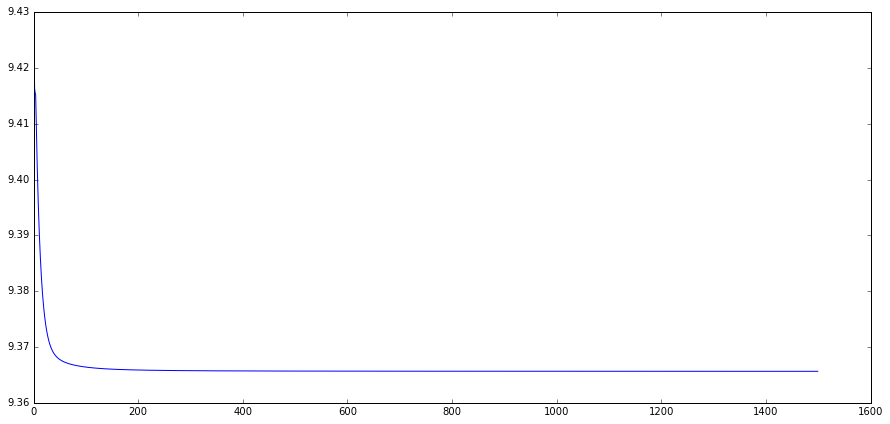

In [22]:
figsize(15,7)
plot(log10(En_array))